# REDES NEURONALES PRACTICA 3 - 2024
# Estadistica de trenes de spikes
Autor: Leano, Alexander

## Introducción
Existen dos archivos: `stimulus.dat` y `spikes.dat`. Corresponden a datos experimentales medidos con electrodos intracelulares por Ariel Rokem en un receptor acústico de un saltamontes.

El archivo stimulate.dat contiene la envolvente de la onda sonora que se presentó al animal mientras se medía la actividad de la neurona. Este estímulo se repitió para cada una de las realizaciones. El archivo contiene dos columnas. La primera indica los tiempos (en milisegundos) y la segunda, la intensidad de la envolvente (en decibeles).

El archivo spikes.dat contiene la respuesta de la neurona. Cada una de las 128 líneas de este archivo representa una realización diferente. Cada realización dura un segundo. Este intervalo de tiempo se divide en 10.000 ventanas (cada una de 0,1 milisegundos de duración). En cada línea del archivo hay una secuencia de ceros o unos, indicando el número de spikes detectados en la ventana correspondiente.

## Analisis preliminar
Primero comenzamos cargando el contenido de los archivos proporcionados para comprender y verificar la estructura de los datos. El contenido se halla en `spikes.dat` y `stimulus.dat`


In [1]:
import numpy as np

# File paths
spikes_file_path = './spikes.dat'
stimulus_file_path = './stimulus.dat'

# Load the spikes data (binary: 0 or 1)
spikes_data = np.loadtxt(spikes_file_path)

# Load the stimulus data (time and intensity in dB)
stimulus_data = np.loadtxt(stimulus_file_path)

# Check the dimensions of both files to understand their structure
spikes_data.shape, stimulus_data.shape

((128, 10000), (10001, 2))

De esta manera obervamos que el archivo `spikes.dat` contiene $128$ filas y $10,000$ columnas, donde cada fila representa una realización diferente y va a ser un `tren de spikes` y cada columna corresponde a una venta de tiempo de $0,1ms$. En cambio el archivo `stimulus.dat` contiene $10.001$ filas y 2 columnas, donde la primera columna representa el tiempo (en milisegundos) y la segunda columna, la intensidad de la envolvente sonora (en decibeles).

Tambien observamos la señal estimulo y dos relización del tren de spikes:

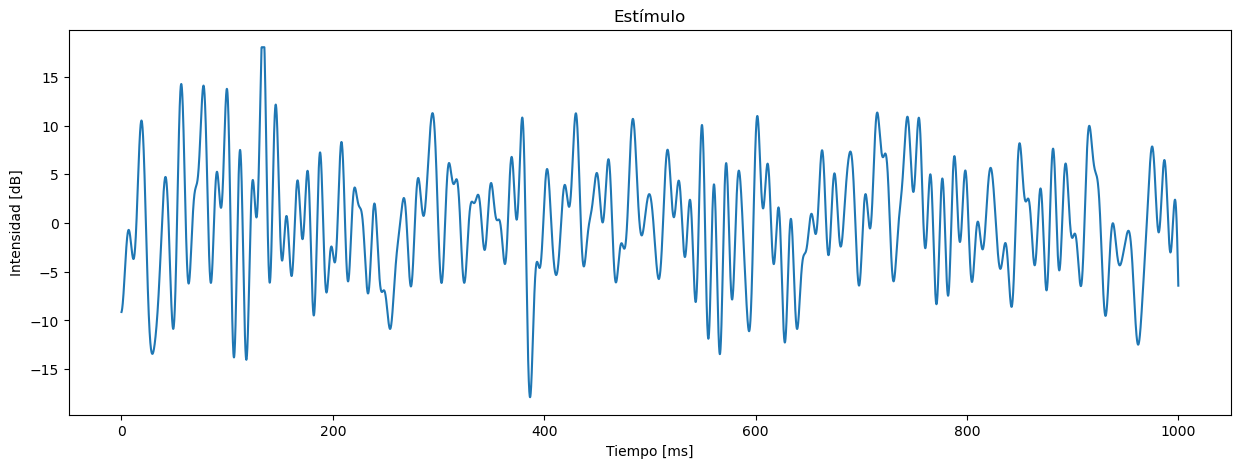

In [2]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,5)
# To rest plt parameters
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

plt.title('Estímulo')
plt.plot(stimulus_data[:,0],stimulus_data[:,1])
plt.xlabel('Tiempo [ms]');
plt.ylabel('Intensidad [dB]');

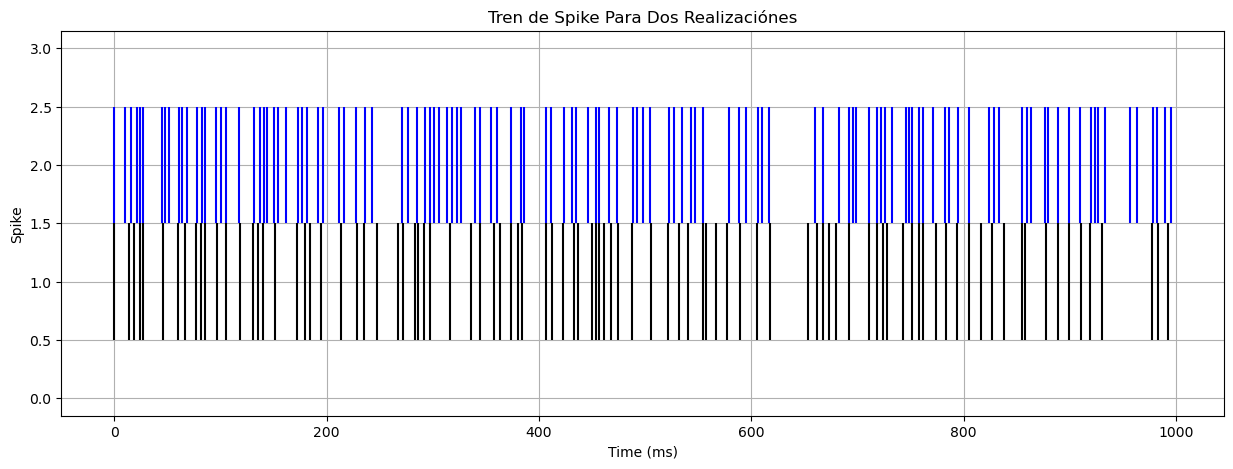

In [3]:
# Select a realization (for example, the first one)
spike_train1 = spikes_data[0]  # Use any index (0 to 127) to select a different realization
# Select a realization (for example, the last one)
spike_train2 = spikes_data[127]  # Use any index (0 to 127) to select a different realization


# Create a time vector for the spike train (each window is 0.1 ms)
# time_vector = np.arange(0, len(spike_train1) * 0.1, 0.1)

# Plot the spike train, data in ms then the index is scaled with 0.1
plt.eventplot(np.where(spike_train1 == 1)[0] * 0.1, lineoffsets=1, colors='black')

plt.eventplot(np.where(spike_train2 == 1)[0] * 0.1, lineoffsets=2, colors='blue')

# plt.plot(time_vector,spike_train,'.' )
plt.title('Tren de Spike Para Dos Realizaciónes')
plt.xlabel('Time (ms)')
plt.ylabel('Spike')
plt.grid(True)
plt.show()

## 1. Intervalo interspikes
<!-- ## 1. Obtener un histograma que se aproxime a la distribución de intervalos $P(\text{ISI})$ de la neurona, considerando todas las realizaciones. Calcular el coeficiente de variabilidad CV. -->
Se calculan los intervalos entre picos (**ISI**: Interpikes Interval) a partir de los datos de los `spikes` para crear el histograma para $P(\text{ISI})$ y luego calcular el coeficiente de variabilidad (**CV**).

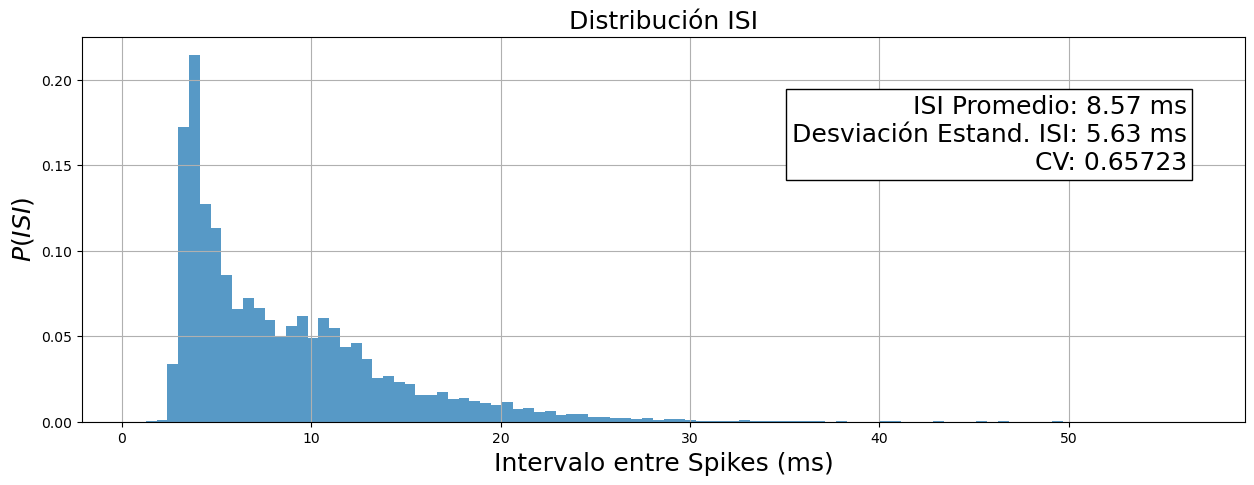

In [4]:
# Calculate the interspike intervals (ISI) for all realizations

# Function to calculate ISIs for a single realization
def calculate_isi(spike_train):
    # Find the indices where spikes occur (spike_train == 1)
    spike_times = np.where(spike_train == 1)[0]
    # Calculate the differences between consecutive spike times (ISI)
    isi = np.diff(spike_times)
    return isi

# Apply the ISI calculation to all realizations and concatenate all ISIs
all_isis = np.concatenate([calculate_isi(spike_train) for spike_train in spikes_data])

# Convert ISIs from indices to milliseconds (each index represents 0.1 ms)
all_isis_ms = all_isis * 0.1

# Calculate the coefficient of variability (CV)
# CV = standard deviation of ISIs / mean of ISIs
mean_isi = np.mean(all_isis_ms)
std_isi = np.std(all_isis_ms)
cv = std_isi / mean_isi

# Plot histogram of ISI distribution and return CV

plt.hist(all_isis_ms, bins='auto', density=True, alpha=0.75)
plt.title('Distribución ISI',fontsize=18)
plt.xlabel('Intervalo entre Spikes (ms)',fontsize=18)
plt.ylabel('$P(ISI)$',fontsize=18)
plt.grid(True)

# Add mean ISI and std ISI as text in the plot
text_str = f'ISI Promedio: {mean_isi:.2f} ms\nDesviación Estand. ISI: {std_isi:.2f} ms\nCV: {cv:.5f}'
plt.text(0.95, 0.85, text_str, transform=plt.gca().transAxes, fontsize=18,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=1))

plt.show()

Teniendo en cuenta todas las realizaciones, el histograma anterior representa la distribución del intervalo entre picos (`ISI`) $P(ISI)$ para la neurona. El coeficiente de variabilidad (CV) calculado es aproximadamente $0,657$. El valor de CV indica la variabilidad de los intervalos entre spikes en relación con la media.

<!-- ## 2 Obtener un histograma que aproxime la probabilidad $P(N)$ de obtener N spikes en una dada realización. Calcular el factor de Fano F. En base a este resultado y al del punto anterior: ¿el proceso de generación de spikes es un proceso tipo renewal? -->

## 2. Cantidad de spikes por realización

Para calcular la distribución de probabilidad $P(N)$ de obtener $N$ picos en una realización dada, es necesario contar el número de spikes en cada realización. Después, podemos calcular el factor de Fano `F`, definido como:
$$
𝐹 = \frac{ \text{Varianza de } N}{\text{Promedio de } N}
$$
 
donde $N$ representa el número de spikes en cada realización.

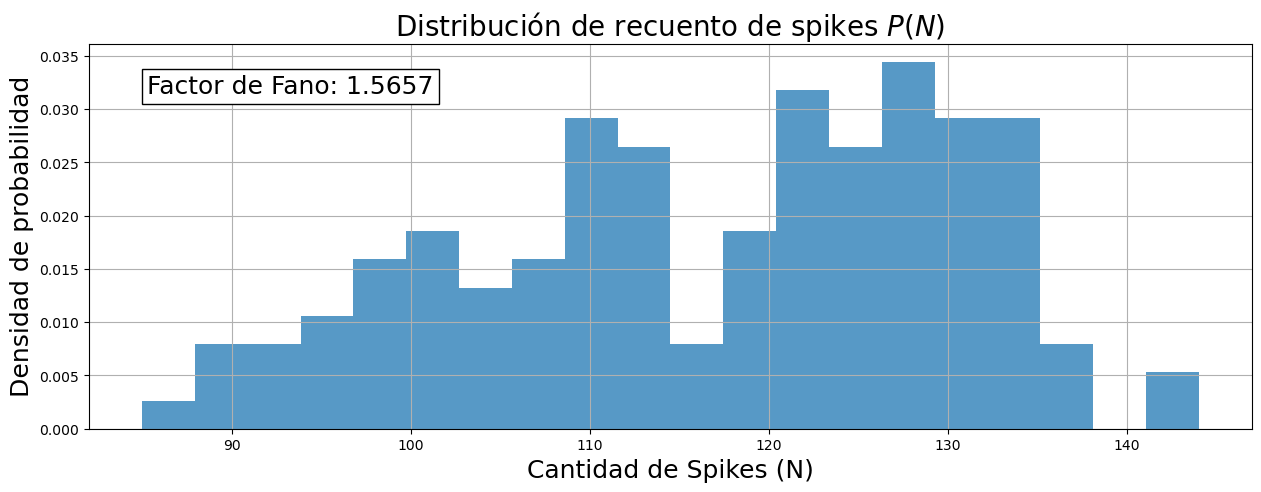

In [5]:
# Calculate the number of spikes (N) in each realization
num_spikes_per_realization = np.sum(spikes_data, axis=1)

# Calculate the Fano factor
mean_spikes = np.mean(num_spikes_per_realization)
var_spikes = np.var(num_spikes_per_realization)
fano_factor = var_spikes / mean_spikes

# Plot histogram for the distribution of spike counts
plt.hist(num_spikes_per_realization, bins=20, density=True, alpha=0.75)
plt.title('Distribución de recuento de spikes $P(N)$',fontsize=20)
plt.xlabel('Cantidad de Spikes (N)',fontsize=18)
plt.ylabel('Densidad de probabilidad',fontsize=18)
plt.grid(True)

# Add Fano factor text in the plot
text_str = f'Factor de Fano: {fano_factor:.4f}'
plt.text(0.05, 0.92, text_str, transform=plt.gca().transAxes, fontsize=18,
         verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=1))

plt.show()





El histograma anterior muestra la distribución de probabilidad $P(N)$, que representa la probabilidad de observar $N$ picos en una realización dada. El factor Fano calculado $F$ es aproximadamente $1,57$.

Un factor Fano mayor que 1 sugiere que el proceso de `generación de spikes` exhibe más variabilidad que un proceso de Poisson (donde
$F$ es igual a 1). Además, teniendos en cuenta el coeficiente de variabilidad ($CV$) del análisis anterior, esto indicaría que el proceso de generación no es puramente `renewal` o de renovación. En un caso de `renewal` los intervalos de spikes serían independientes y se distribuirían de manera idéntica. La variabilidad observada sugiere una dinámica más compleja.

<!-- ## 3 Estimar la tasa de disparo dependiente del tiempo $r(t)$, promediando todas la realizaciones y usando un tamaño de bin adecuado. -->

## 3. Tasa de disparo dependiente del tiempo $r(t)$

Para estimar la tasa de disparo $r(t)$, promediamos los recuentos de spikes en todas las realizaciones en intervalos de tiempo. La tasa de disparo en cada bin se calcula como:

$$
r(t) = \frac{1}{N} \sum_{i=1}^{N} \frac{S_i(t)}{\Delta t_{\text{bin}}}
$$

donde:
- $ N $ el numero total de realizacion (128 en este caso),
- $ S_i(t) $ el numero de spikes $i$-esimo durante el intervalo ${\Delta t}_{\text{bin}} $ ,
- $ {\Delta t}_{\text{bin}} $ es el tamaño del bin en tiempo (milisegundos).

#### Procedimiento:
1. Elegir un tamaño de bin adecuado (1 ms) para promediar los recuentos de spikes a lo largo del tiempo.
2. Para cada intervalo de tiempo sumar todos los spikes (solo hay 0 o 1 donde los 1 son los spikes).
3. Dividir la suma por el número total de realizaciones y la duración del bin (convertido a segundos) para obtener la tasa de disparo en HZ.





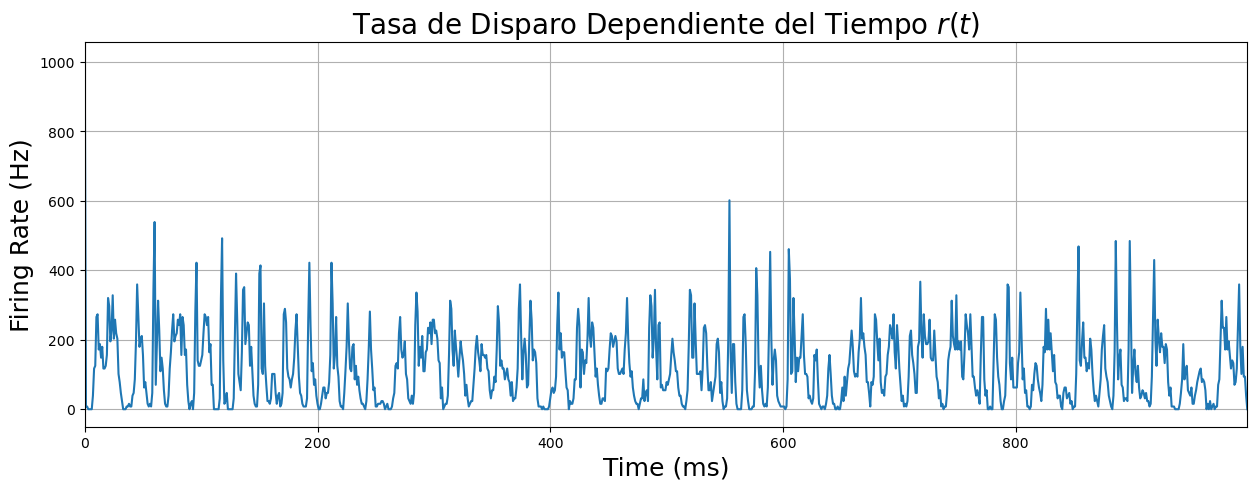

In [6]:
# Define the bin size in milliseconds and the corresponding number of time windows
bin_size_ms = 1  # Bin size in ms
bin_size_windows = int(bin_size_ms / 0.1)  # Convert to number of windows (0.1 ms each)
delta_t_bin_size_s = bin_size_ms / 1000 # Used to calculate the firing rate in Hz

# Initialize the firing rate array
num_bins = spikes_data.shape[1] // bin_size_windows
firing_rate = np.zeros(num_bins)

# Compute the firing rate for each bin
for bin_idx in range(num_bins):
    # Calculate the start and end indices for the current bin
    start_idx = bin_idx * bin_size_windows
    end_idx = start_idx + bin_size_windows
    # Count the spikes across all realizations in the current bin
    total_number_of_spike = np.sum(spikes_data[:, start_idx:end_idx])
    # Average Fire rate for a bean across all realizations
    firing_rate[bin_idx] = (total_number_of_spike / delta_t_bin_size_s )/ spikes_data.shape[0]  # Convert to Hz

# Time vector for the firing rate
time_vector = np.arange(0, num_bins * bin_size_ms, bin_size_ms)

# Plot the time-dependent firing rate
plt.plot(time_vector, firing_rate)
plt.title('Tasa de Disparo Dependiente del Tiempo $r(t)$',fontsize=20)
plt.xlabel('Time (ms)',fontsize=18)
plt.ylabel('Firing Rate (Hz)',fontsize=18)
plt.grid(True)
plt.xlim(0, time_vector[-1])

plt.show()

# firing_rate


<!-- ## 4 Calcular el filtro asociado a esta neurona, que da la mejor prediccion lineal del histograma dependiente del tiempo $r(t)$. Despreciar el tiempo de autocorrelación del estímulo. -->
## 4. Filtro asociado

Siendo que el estimulo se puede elegir y controlar se puede utilizar ruido blando. Al suponer que las propiedades estadísticas del estímulo son parecidas a las del ruido blanco, se puede llegar a un el filtro adaptado:

$$
D(\tau) = \frac{Q_{rs}}{\sigma^2}
$$

donde:

$$
Q_{rs}(-\tau) = \sum_{\text{spikes}} S(t_{\text{spike}} - \tau)
$$

siendo $S(t)$ es el estímulo dependiente del tiempo.



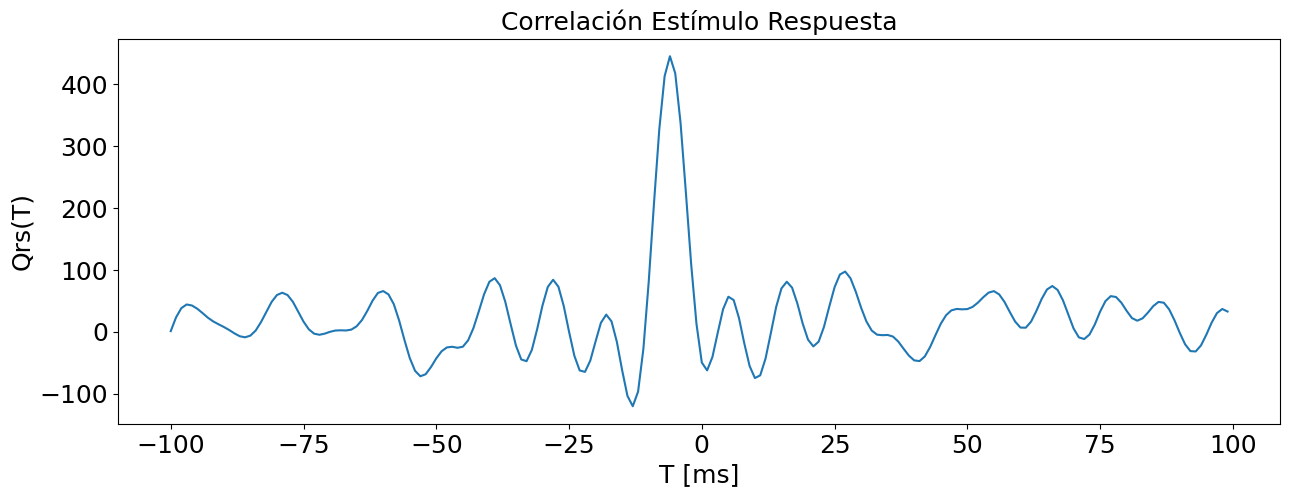

In [7]:
def Qrs(T):
    """
    Function to calculate the sum of the stimulus values at specific time shifts T, weighted by the spikes occurrences
    Param
        T: Time in ms.
    """
    acum=0
    idx_shift = T*10
    array_len = stimulus_data.shape[0]
    
    for i in range(spikes_data.shape[0]):
        acum+=np.sum(stimulus_data[:,1][(np.array( np.where(spikes_data[i,:]==True) )+idx_shift) % array_len])
    return acum/spikes_data.shape[0]

result=np.zeros(200)
x=np.linspace(-100,99,200)
for i in range(200):
    result[i]=Qrs(int(x[i]))

plt.title('Correlación Estímulo Respuesta',fontsize=18)
plt.xlabel('T [ms]',fontsize=18)
plt.ylabel('Qrs(T)',fontsize=18)
plt.plot(x,result)
plt.tick_params(labelsize = 18)

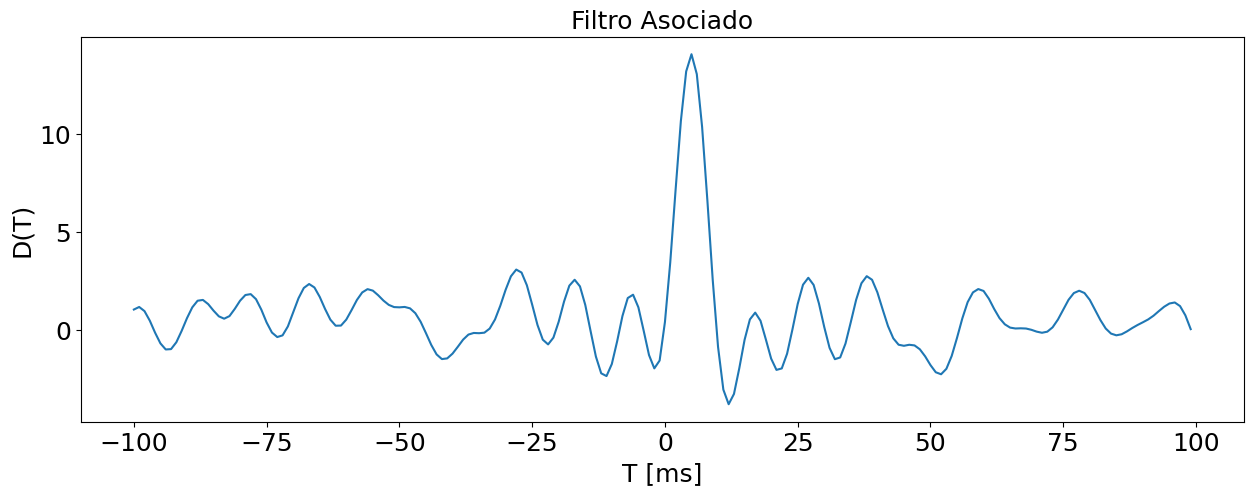

In [8]:
D=result[::-1]/np.var(stimulus_data[:,1])

plt.title('Filtro Asociado',fontsize=18)
plt.xlabel('T [ms]',fontsize=18)
plt.ylabel('D(T)',fontsize=18)
plt.plot(x,D)
plt.tick_params(labelsize = 18)

Y es asi que obtenemos el filtro asociado a esta neurona, que da la mejor prediccion lineal del histograma dependiente del tiempo $r(t)$